# Test passive membrane properties using neurons with different time constants

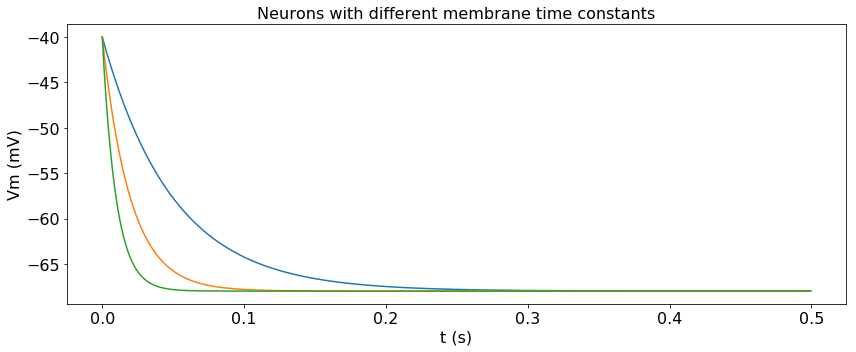

In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ntwk import LIFNtwk
from plot import set_font_size


t_m = np.array([0.05, 0.02, 0.01])
e_l = -0.068 * np.ones(3)
v_th = -0.036 * np.ones(3)
v_reset = -0.068 * np.ones(3)
t_r = 0.002 * np.ones(3)
es_syn = {'AMPA': 0}
ts_syn = {'AMPA': 0.002}
ws_rcr = {'AMPA': np.zeros((3, 3))}
ws_up = {'AMPA': np.eye(3)}

dt = 0.0005
ts = np.arange(0, 0.5, dt)
spks_up = np.zeros((len(ts), 3))

vs_0 = -0.04 * np.ones(3)

ntwk = LIFNtwk(
    t_m=t_m, e_l=e_l, v_th=v_th, v_reset=v_reset, t_r=t_r,
    es_syn=es_syn, ts_syn=ts_syn, ws_rcr=ws_rcr, ws_up=ws_up)

resp = ntwk.run(spks_up=spks_up, dt=dt, vs_0=vs_0)

fig, ax = plt.subplots(1, 1, figsize=(12, 5), tight_layout=True)

ax.plot(ts, 1000 * resp.vs)
ax.set_xlabel('t (s)')
ax.set_ylabel('Vm (mV)')
ax.set_title('Neurons with different membrane time constants')

set_font_size(ax, 16)

# Extend to case of synaptic-input-induced spiking

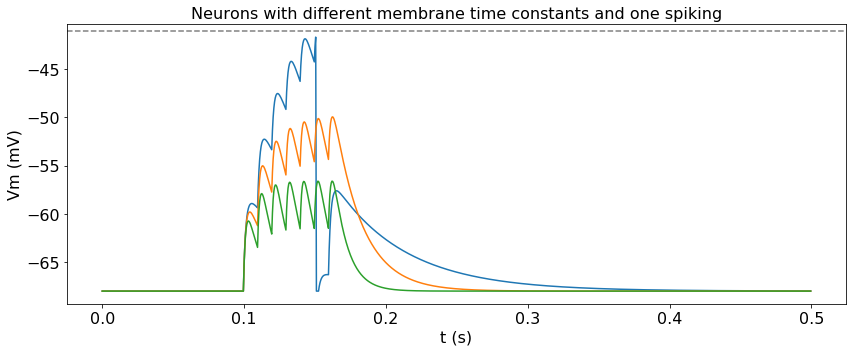

In [2]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ntwk import LIFNtwk
from plot import set_font_size


t_m = np.array([0.05, 0.02, 0.01])
e_l = -0.068 * np.ones(3)
v_th = -0.041 * np.ones(3)
v_reset = -0.068 * np.ones(3)
t_r = 0.002 * np.ones(3)
es_syn = {'AMPA': 0}
ts_syn = {'AMPA': 0.002}
ws_rcr = {'AMPA': np.zeros((3, 3))}
ws_up = {'AMPA': 0.04 * np.eye(3)}

dt = 0.0005
ts = np.arange(0, 0.5, dt)
spks_up = np.zeros((len(ts), 3))
ts_spks_up = [0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16]

for t in ts_spks_up:
    spks_up[int(t/dt), :] = 1

ntwk = LIFNtwk(
    t_m=t_m, e_l=e_l, v_th=v_th, v_reset=v_reset, t_r=t_r,
    es_syn=es_syn, ts_syn=ts_syn, ws_rcr=ws_rcr, ws_up=ws_up)

resp = ntwk.run(spks_up=spks_up, dt=dt)

fig, ax = plt.subplots(1, 1, figsize=(12, 5), tight_layout=True)

ax.plot(ts, 1000 * resp.vs)
ax.axhline(-41, color='gray', ls='--')

ax.set_xlabel('t (s)')
ax.set_ylabel('Vm (mV)')
ax.set_title('Neurons with different membrane time constants and one spiking')

set_font_size(ax, 16)

# Test afterhyperpolarization

Here we show a neuron's response to tetanic stimulus with and without afterhyperpolarization.

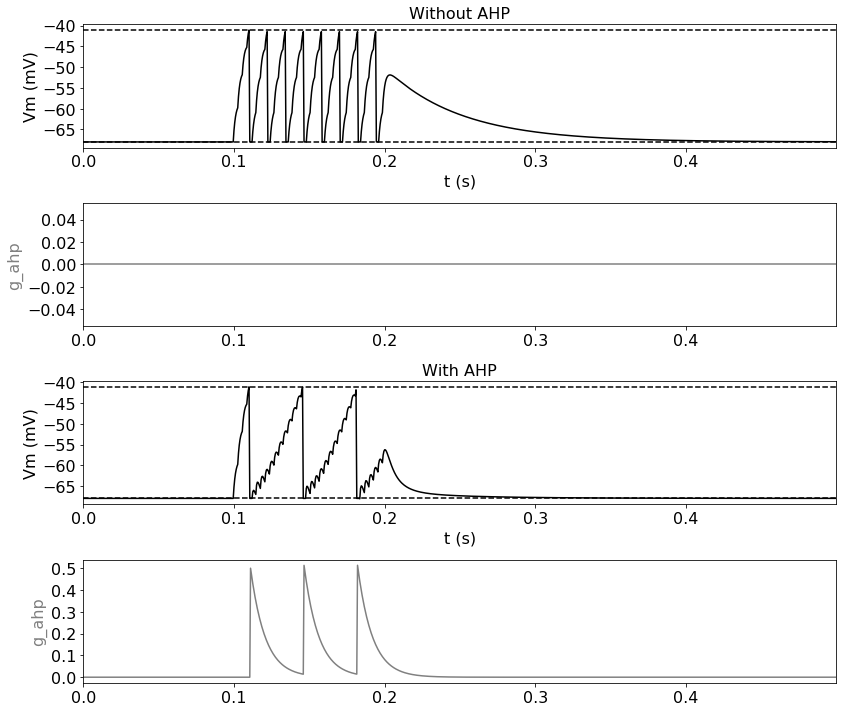

In [3]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ntwk import LIFNtwk
from plot import set_font_size


t_m = np.array([0.05])
e_l = -0.068 * np.ones(1)
v_th = -0.041 * np.ones(1)
v_reset = -0.068 * np.ones(1)
t_r = 0.002 * np.ones(1)
e_ahp = -0.07
t_ahp = 0.01
w_ahp = 0.5
es_syn = {'AMPA': 0}
ts_syn = {'AMPA': 0.002}
ws_rcr = {'AMPA': np.zeros((1, 1))}
ws_up = {'AMPA': 0.04 * np.eye(1)}

dt = 0.0005
ts = np.arange(0, 0.5, dt)

# set up input spikes
spks_up = np.zeros((len(ts), 1))
ts_spks_up = np.arange(0.1, 0.2, 0.003)

for t in ts_spks_up:
    spks_up[int(t/dt), 0] = 1

# run basic ntwk
ntwk_basic = LIFNtwk(
    t_m=t_m, e_l=e_l, v_th=v_th, v_reset=v_reset, t_r=t_r,
    es_syn=es_syn, ts_syn=ts_syn, ws_rcr=ws_rcr, ws_up=ws_up)

rsp_basic = ntwk_basic.run(spks_up=spks_up, dt=dt)

# run ntwk with nonzero AHP term
ntwk_ahp = LIFNtwk(
    t_m=t_m, e_l=e_l, v_th=v_th, v_reset=v_reset, t_r=t_r,
    e_ahp=e_ahp, t_ahp=t_ahp, w_ahp=w_ahp,
    es_syn=es_syn, ts_syn=ts_syn, ws_rcr=ws_rcr, ws_up=ws_up)

rsp_ahp = ntwk_ahp.run(spks_up=spks_up, dt=dt)

rsps = [rsp_basic, rsp_ahp]
titles = ['Without AHP', 'With AHP']

# plot both ntwk responses
fig, axs = plt.subplots(4, 1, figsize=(12, 10), tight_layout=True)
axs = [axs[:2], axs[2:]]

for axs_, rsp, title in zip(axs, rsps, titles):
    
    axs_[0].plot(ts, 1000 * rsp.vs, color='k')
    axs_[0].axhline(1000*e_l, color='k', ls='--')
    axs_[0].axhline(1000*v_th, color='k', ls='--')
    axs_[0].set_xlim(ts[0], ts[-1])
    
    axs_[0].set_xlabel('t (s)')
    axs_[0].set_ylabel('Vm (mV)')
    axs_[0].set_title(title)
    
    axs_[1].plot(ts, rsp.g_ahp, color='gray')
    axs_[1].set_xlim(ts[0], ts[-1])

    axs_[1].set_ylabel('g_ahp', color='gray')
    
    for ax in axs_:
        set_font_size(ax, 16)

# Test forcing network's voltages and spikes

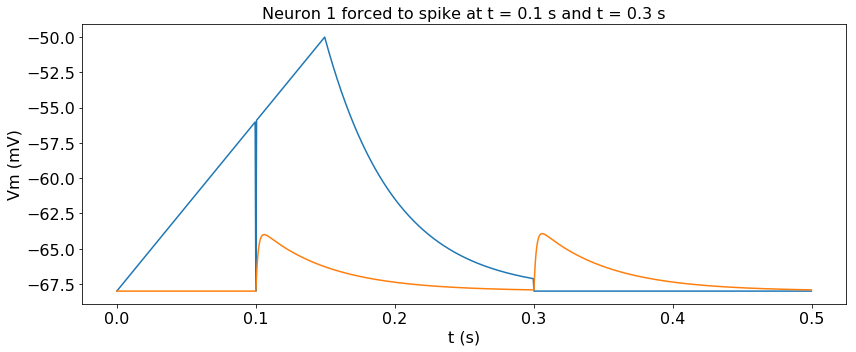

In [4]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ntwk import LIFNtwk
from plot import set_font_size


t_m = np.array([0.05, 0.05])
e_l = -0.068 * np.ones(2)
v_th = -0.036 * np.ones(2)
v_reset = -0.068 * np.ones(2)
t_r = 0.002 * np.ones(2)
es_syn = {'AMPA': 0}
ts_syn = {'AMPA': 0.002}
ws_rcr = {'AMPA': np.array([[0., 0], [0.017, 0]])}
ws_up = {'AMPA': np.zeros((2, 2))}

dt = 0.0005
ts = np.arange(0, 0.5, dt)
spks_up = np.zeros((len(ts), 2))

vs_forced = np.array([np.linspace(-0.068, -0.050, 300), np.nan * np.zeros(300)]).T

spks_forced = np.zeros((601, 2))
spks_forced[200, 0] = 1
spks_forced[600, 0] = 1

ntwk = LIFNtwk(
    t_m=t_m, e_l=e_l, v_th=v_th, v_reset=v_reset, t_r=t_r,
    es_syn=es_syn, ts_syn=ts_syn, ws_rcr=ws_rcr, ws_up=ws_up)

rsp = ntwk.run(spks_up=spks_up, dt=dt, vs_forced=vs_forced, spks_forced=spks_forced)

fig, ax = plt.subplots(1, 1, figsize=(12, 5), tight_layout=True)

ax.plot(ts, 1000 * rsp.vs)
ax.set_xlabel('t (s)')
ax.set_ylabel('Vm (mV)')
ax.set_title('Neuron 1 forced to spike at t = 0.1 s and t = 0.3 s')

set_font_size(ax, 16)

# Test cells with different refractory periods

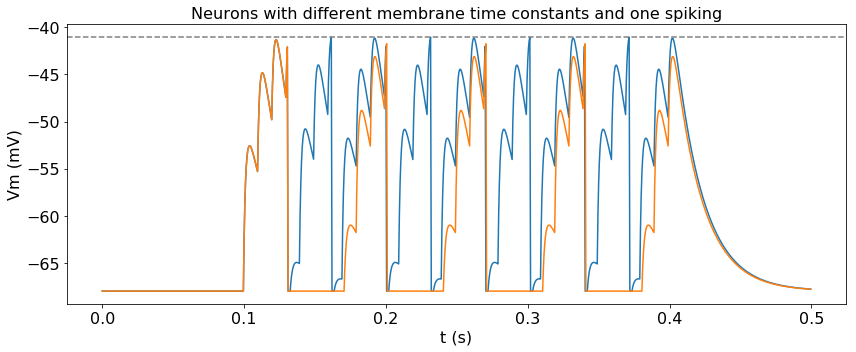

In [5]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ntwk import LIFNtwk
from plot import set_font_size


t_m = 0.02 * np.ones(2)
e_l = -0.068 * np.ones(2)
v_th = -0.041 * np.ones(2)
v_reset = -0.068 * np.ones(2)
t_r = np.array([.002, .04])
es_syn = {'AMPA': 0}
ts_syn = {'AMPA': 0.002}
ws_rcr = {'AMPA': np.zeros((2, 2))}
ws_up = {'AMPA': 0.08 * np.eye(2)}

dt = 0.0005
ts = np.arange(0, 0.5, dt)
spks_up = np.zeros((len(ts), 2))
ts_spks_up = np.arange(.1, .4, .01)

for t in ts_spks_up:
    spks_up[int(t/dt), :] = 1

ntwk = LIFNtwk(
    t_m=t_m, e_l=e_l, v_th=v_th, v_reset=v_reset, t_r=t_r,
    es_syn=es_syn, ts_syn=ts_syn, ws_rcr=ws_rcr, ws_up=ws_up)

resp = ntwk.run(spks_up=spks_up, dt=dt)

fig, ax = plt.subplots(1, 1, figsize=(12, 5), tight_layout=True)

ax.plot(ts, 1000 * resp.vs)
ax.axhline(-41, color='gray', ls='--')

ax.set_xlabel('t (s)')
ax.set_ylabel('Vm (mV)')
ax.set_title('Neurons with different membrane time constants and one spiking')

set_font_size(ax, 16)

# Test high resting potential vs excitatory barrage equivalence

In [6]:
%reset -f
%matplotlib inline
import pdb
import matplotlib.pyplot as plt
import numpy as np

from ntwk import LIFNtwk
from plot import set_font_size

import PARAMETERS as P

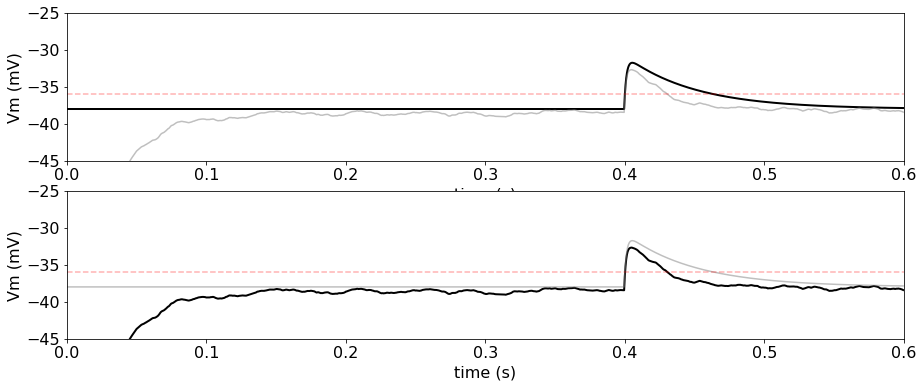

In [7]:
W_A_PC_EC = 0.0001
W_A_PC_PC = 0.05
RATE_EC = 38000
DUR = 0.6
STIM = 0.4
SEED = 6

np.random.seed(SEED)

# upstream weight matrices
w_up_a = np.array([
    #       EC      PC_UP
    [       0., W_A_PC_PC],
    [W_A_PC_EC, W_A_PC_PC],
])

w_up_n = np.array([
    #       EC      PC_UP
    [       0.,        0.],
    [       0.,        0.],
])

# upstream spk inputs
t = np.arange(0, DUR, P.DT)
# 1st col EC, 2nd col upstream PC
spks_up = np.zeros((len(t), 2))

# EC barrage
spks_up[:, 0] = np.random.poisson(RATE_EC*P.DT, t.shape)
# upstream PC input
spks_up[int(STIM/P.DT), 1] = 1

# make ntwk
ntwk = LIFNtwk(
    t_m=P.T_M_PC,
    e_l=np.array([P.E_L_PC + 0.03, P.E_L_PC]),
    v_th=100, v_reset=P.V_RESET_PC, t_r=np.repeat(P.T_R_PC, 2),
    es_syn={'AMPA': P.E_A, 'NMDA': P.E_N}, ts_syn={'AMPA': P.T_A, 'NMDA': P.T_N},
    ws_up={'AMPA': w_up_a, 'NMDA': w_up_n},
    ws_rcr={'AMPA': np.zeros((2, 2)), 'NMDA': np.zeros((2, 2))},
)

# run ntwk
vs_0 = np.array([P.E_L_PC + 0.03, P.E_L_PC])
rsp = ntwk.run(spks_up=spks_up, dt=P.DT, vs_0=vs_0)

# plot results
fig, axs = plt.subplots(2, 1, figsize=(15, 6))
axs[0].plot(t, 1000*rsp.vs[:, 0], color='k', lw=2)
axs[0].plot(t, 1000*rsp.vs[:, 1], color='gray', alpha=0.5)
axs[1].plot(t, 1000*rsp.vs[:, 1], color='k', lw=2)
axs[1].plot(t, 1000*rsp.vs[:, 0], color='gray', alpha=0.5)

for ax in axs:
    ax.axhline(1000*P.V_TH_PC, color='r', ls='--', alpha=0.3)
    
    ax.set_xlim(0, DUR)
    ax.set_ylim(-45, -25)
    
    ax.set_xlabel('time (s)')
    ax.set_ylabel('Vm (mV)')
    
    set_font_size(ax, 16)

Test passed if the gray and green EPSPs are about the same size in both panels.